In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-tot_chl_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
print result.columns

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)
print sds.columns


Index([u'tot_chl', u'Cruise', u'Day', u'File_Id'], dtype='object')
Index([u'Day', u'LAT', u'LON', u'File_Id', u'T', u'S', u'Cruise'], dtype='object')


In [3]:
# join sds dataframe to opp file averages

print sds.shape
#print type(sds), type(cIdx[9])
#new_table = pd.merge(sds, result, how="inner")
new_table = pd.merge(sds, result, how="inner")


#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['tot_chl']].values 

(65382, 7)


In [4]:
# identify continuous transects
# start by just picking out cruises that we know fit the bill

# look at how the clusters relate to physical properties of the water column...

cr = 'Tokyo_2'
crsub = new_table[(new_table['Cruise']==cr)].sort(['Day','File_Id'],ascending=[1,1])
crsub['density'] = sw.rho(crsub['S'].values,crsub['T'].values,0)

cxx = (crsub['LON']).values # longitude
cyy = (crsub['LAT']).values # latitude

# convert all longitude to longitude east
cxx[cxx<0]= 360+cxx[cxx<0];
cxbew = cxx
cxbew[cxbew>180] = cxbew[cxbew>180]-360

# calculate distance between points
cdistance = sw.distance(cxbew,cyy, 0)[0]
crsub['cdistance']= np.insert(cdistance,0,0)

ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)
crsub['ctrack'] = ctrack


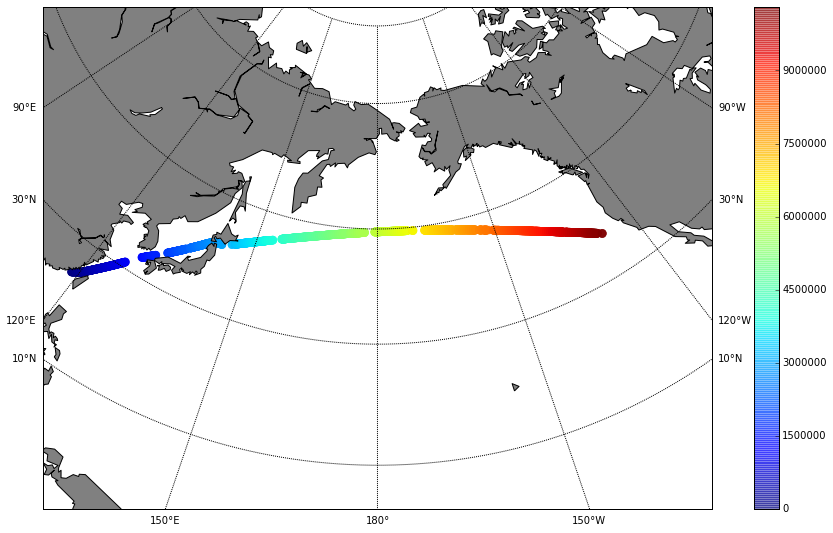

24.159257


49.568571999999996

In [5]:
# plot the cruise track

fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(cxbew,cyy)
#m.scatter(xm, ym, s=75, c=crsub['tot_chl'], alpha=.5,lw=0)
m.scatter(xm, ym, s=75, c=ctrack, alpha=.5,lw=0)

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])


plt.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar()
plt.show()

print cyy.min(); cyy.max()

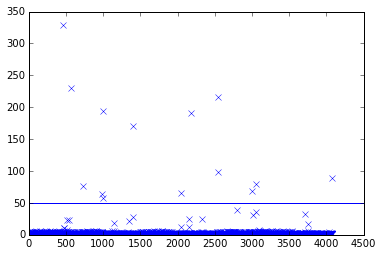

In [6]:
plt.plot(cdistance/1000,'x')
plt.axhline(50)
plt.show()


In [7]:
# "continuous" tracks of data are found between 
# 0:517 519:627 629:817 819:1109 1123:1576 1578:2281 2283:2435 2437:2838 2847:3353 3421:4570
# now turn these into 3 separate datasets, track1, track2 and track3
# check the length of these tracks

beg = [0, 519, 629, 819, 1123, 1578, 2283, 2437, 2847, 3421]
fin = [517, 627, 817, 1109, 1576, 2281, 2435, 2838, 3353, 4570]

track_lengths = np.zeros(len(beg))
mean_dist = np.zeros(len(beg))
for nn in range(len(beg)):
    track_lengths[nn] = ctrack[fin[nn]]-ctrack[beg[nn]]
    mean_dist[nn] = cdistance[beg[nn]:fin[nn]].mean()/1000
    
print track_lengths/1000
print mean_dist
    
# split the subset into tracks
t1sub = crsub.iloc[0:517]
t2sub = crsub.iloc[519:627]
t3sub = crsub.iloc[629:817]
t4sub = crsub.iloc[819:1109]
t5sub = crsub.iloc[1123:1576]
t6sub = crsub.iloc[1578:2281]
t7sub = crsub.iloc[2283:2435]
t8sub = crsub.iloc[2437:2838]
t9sub = crsub.iloc[2847:3353]
t10sub = crsub.iloc[3421:4570]

# split the tracks
t1track = ctrack[0:517]-ctrack[0]
t2track = ctrack[519:627]-ctrack[519]
t3track = ctrack[629:817]-ctrack[629]
t4track = ctrack[819:1109]-ctrack[819]
t5track = ctrack[1123:1576]-ctrack[1123]
t6track = ctrack[1578:2281]-ctrack[1578]
t7track = ctrack[2283:2435]-ctrack[2283]
t8track = ctrack[2437:2838]-ctrack[2437]
t9track = ctrack[2847:3353]-ctrack[2847]
t10track = ctrack[3421:4570]-ctrack[3421]


# check the effective resolution for the tracks
print cdistance[63:950].mean()/1000



IndexError: index 4570 is out of bounds for axis 0 with size 4083

In [ ]:
# interpolate the tracks onto a regular n km grid
# set the interpolation scale, n
n = 1.5

t1x = np.arange(0,track_lengths[0]+1000, n*1000)
t1int = np.interp(t1x,t1track,t1sub['tot_chl'].values)
t1intT = np.interp(t1x,t1track,t1sub['T'].values)

t2x = np.arange(0,track_lengths[1]+1000, n*1000)
t2int = np.interp(t2x,t2track,t2sub['tot_chl'].values)
t2intT = np.interp(t2x,t2track,t2sub['T'].values)

t3x = np.arange(0,track_lengths[2]+1000, n*1000)
t3int = np.interp(t3x,t3track,t3sub['tot_chl'].values)
t3intT = np.interp(t3x,t3track,t3sub['T'].values)

t4x = np.arange(0,track_lengths[3]+1000, n*1000)
t4int = np.interp(t4x,t4track,t4sub['tot_chl'].values)
t4intT = np.interp(t4x,t4track,t4sub['T'].values)

t5x = np.arange(0,track_lengths[4]+1000, n*1000)
t5int = np.interp(t5x,t5track,t5sub['tot_chl'].values)
t5intT = np.interp(t5x,t5track,t5sub['T'].values)

t6x = np.arange(0,track_lengths[5]+1000, n*1000)
t6int = np.interp(t6x,t6track,t6sub['tot_chl'].values)
t6intT = np.interp(t6x,t6track,t6sub['T'].values)

t7x = np.arange(0,track_lengths[6]+1000, n*1000)
t7int = np.interp(t7x,t7track,t7sub['tot_chl'].values)
t7intT = np.interp(t7x,t7track,t7sub['T'].values)

t8x = np.arange(0,track_lengths[7]+1000, n*1000)
t8int = np.interp(t8x,t8track,t8sub['tot_chl'].values)
t8intT = np.interp(t8x,t8track,t8sub['T'].values)

t9x = np.arange(0,track_lengths[8]+1000, n*1000)
t9int = np.interp(t9x,t9track,t9sub['tot_chl'].values)
t9intT = np.interp(t9x,t9track,t9sub['T'].values)

t10x = np.arange(0,track_lengths[9]+1000, n*1000)
t10int = np.interp(t10x,t10track,t10sub['tot_chl'].values)
t10intT = np.interp(t10x,t10track,t10sub['T'].values)


plt.plot(t1x/1000,t1int,t1track/1000,t1sub['tot_chl'].values,'x')
plt.show()

plt.plot(t3x/1000,t3int,t3track/1000,t3sub['tot_chl'].values,'x')
plt.show()

In [ ]:
# grab subsets of each track, detrend them and do autocorrelation to get decorrelation length scale
# track 1

#plt.plot(t1x[0:100]/1000,detrend(t1int[0:100], order=1))
#plt.show()

#plt.plot(t3x[0:100]/1000,detrend(t3int[0:100], order=1))
#plt.show()
plt.hold(True)
plt.plot(acf(detrend(t1int[0:200], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t1intT[0:200], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()

plt.hold(True)
plt.plot(acf(detrend(t3int[0:200], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t3intT[0:200], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()



In [ ]:
# grab subsets of each track, detrend them and do autocorrelation to get decorrelation length scale
# track 1

#plt.plot(t1x[0:100]/1000,detrend(t1int[0:100], order=1))
#plt.show()

#plt.plot(t3x[0:100]/1000,detrend(t3int[0:100], order=1))
#plt.show()
plt.hold(True)
plt.plot(acf(detrend(t1int[100:300], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t1intT[100:300], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()

plt.hold(True)
plt.plot(acf(detrend(t3int[100:300], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t3intT[100:300], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()



In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t1int
data_inT = t1intT
x_in = t1x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind]))*n)
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n
    
decorr_l1 = decorr_l
decorr_lT1 = decorr_lT
decorr_track1 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track1,decorr_l1,'b')
plt.plot(decorr_track1,decorr_lT1,'r')
plt.plot(t1track/1000,t1sub['LAT'],'--k')
plt.plot(t1track/1000,t1sub['T'],'k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t2int
data_inT = t2intT
x_in = t2x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l2 = decorr_l
decorr_lT2 = decorr_lT
decorr_track2 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track2,decorr_l2,'b')
plt.plot(decorr_track2,decorr_lT2,'r')
plt.xlim([0, np.max(x_in)/1000])
plt.plot(t2track/1000,t2sub['LAT'],'--k')
plt.plot(t2track/1000,t2sub['T'],'k')
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t3int
data_inT = t3intT
x_in = t3x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l3 = decorr_l
decorr_lT3 = decorr_lT
decorr_track3 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track3,decorr_l3,'b')
plt.plot(decorr_track3,decorr_lT3,'r')
plt.plot(t3track/1000,t3sub['LAT'],'--k')
plt.plot(t3track/1000,t3sub['T'],'k')

plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t4int
data_inT = t4intT
x_in = t4x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l4 = decorr_l
decorr_lT4 = decorr_lT
decorr_track4 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track4,decorr_l4,'b')
plt.plot(decorr_track4,decorr_lT4,'r')
plt.plot(t4track/1000,t4sub['LAT'],'--k')
plt.plot(t4track/1000,t4sub['T'],'k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t5int
data_inT = t5intT
x_in = t5x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l5 = decorr_l
decorr_lT5 = decorr_lT
decorr_track5 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track5,decorr_l5,'b')
plt.plot(decorr_track5,decorr_lT5,'r')
plt.plot(t5track/1000,t5sub['LAT'],'--k')
plt.plot(t5track/1000,t5sub['T'],'k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t6int
data_inT = t6intT
x_in = t6x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l6 = decorr_l
decorr_lT6 = decorr_lT
decorr_track6 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track6,decorr_l6,'b')
plt.plot(decorr_track6,decorr_lT6,'r')
plt.plot(t6track/1000,t6sub['LAT'],'--k')
plt.plot(t6track/1000,t6sub['T'],'k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()



In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t7int
data_inT = t7intT
x_in = t7x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l7 = decorr_l
decorr_lT7 = decorr_lT
decorr_track7 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track7,decorr_l7,'b')
plt.plot(decorr_track7,decorr_lT7,'r')
plt.plot(t7track/1000,t7sub['LAT'],'--k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t8int
data_inT = t8intT
x_in = t8x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l8 = decorr_l
decorr_lT8 = decorr_lT
decorr_track8 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track8,decorr_l8,'b')
plt.plot(decorr_track8,decorr_lT8,'r')
plt.plot(t8track/1000,t8sub['LAT'],'--k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t9int
data_inT = t9intT
x_in = t9x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n

    
decorr_l9 = decorr_l
decorr_lT9 = decorr_lT
decorr_track9 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track9,decorr_l9,'b')
plt.plot(decorr_track9,decorr_lT9,'r')
plt.plot(t9track/1000,t9sub['LAT'],'--k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

In [ ]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t10int
data_inT = t10intT
x_in = t10x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n
    

    
decorr_l10 = decorr_l
decorr_lT10 = decorr_lT
decorr_track10 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track10,decorr_l10,'b')
plt.plot(decorr_track10,decorr_lT10,'r')
plt.plot(t10track/1000,t10sub['LAT'],'--k')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()